# 수업을 위한 사전 세팅

In [1]:
#구글 drive 연결
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#작업을 수행할 디렉토리로 이동하기기
%cd gdrive/MyDrive/AIED_CON

/content/gdrive/MyDrive/AIED_CON


In [3]:
#필요한 패키지 다운받기기
!pip install torchmetrics
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00


# CNN 설명

# CNN을 이용한 Classification 문제 만들기

## 데이터셋을 정의해서 데이터 불러오기

In [4]:
#데이터셋을 정의
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import os 

class AnimalDataset(Dataset):
  def __init__(self, transform = None):
    '''
    라벨링 : 
      포유류 : 0 [1,0,0,0]
      새 : 1 [0,1,0,0]
      파충류 : 2 [0,0,1,0]
      어류 : 3 [0,0,0,1]
    '''
    self.path1 = "labeleddata/mammal"
    self.path2 = "labeleddata/bird"
    self.path3 = "labeleddata/reptile"
    self.path4 = "labeleddata/fish"
    if transform != None :
      self.transform = transform
    else : 
      self.transform = transforms.Compose([transforms.PILToTensor()])
    self.image_list = []
    self.get_image_list()

  def get_image_list(self):
    for a in os.listdir(self.path1):
      self.image_list.append((self.path1+"/"+a, torch.tensor([1,0,0,0])))
    for a in os.listdir(self.path2):
      self.image_list.append((self.path2+"/"+a, torch.tensor([0,1,0,0])))
    for a in os.listdir(self.path3):
      self.image_list.append((self.path3+"/"+a, torch.tensor([0,0,1,0])))
    for a in os.listdir(self.path4):
      self.image_list.append((self.path4+"/"+a, torch.tensor([0,0,0,1])))

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    path = self.image_list[idx][0]
    image = Image.open(path)
    sample = image.resize((200,200)).convert("RGB")
    sample = self.transform(sample)
    sample = sample/255
    return dict(image = sample,
                label = self.image_list[idx][1],
                acc_label = torch.argmax(self.image_list[idx][1]))

In [5]:
#데이터셋을 정의하고 예시로 추출해보기기
DS = AnimalDataset()
print("===========================================")
print("숫자로 이미지 표현")
print(DS[0]["image"])
print("===========================================")
print("벡터로 라벨 표현")
print(DS[0]["label"])
print("===========================================")
print("대응되는 라벨 표현")
print(DS[0]["acc_label"])

숫자로 이미지 표현
tensor([[[0.9882, 0.9882, 0.9882,  ..., 0.9412, 0.9412, 0.9412],
         [0.9882, 0.9882, 0.9882,  ..., 0.9412, 0.9412, 0.9412],
         [0.9882, 0.9882, 0.9882,  ..., 0.9412, 0.9412, 0.9412],
         ...,
         [0.9490, 0.9490, 0.9490,  ..., 0.9098, 0.9098, 0.9098],
         [0.9490, 0.9490, 0.9490,  ..., 0.9098, 0.9098, 0.9098],
         [0.9490, 0.9490, 0.9490,  ..., 0.9098, 0.9098, 0.9098]],

        [[0.9922, 0.9922, 0.9922,  ..., 0.9216, 0.9216, 0.9216],
         [0.9922, 0.9922, 0.9922,  ..., 0.9216, 0.9216, 0.9216],
         [0.9922, 0.9922, 0.9922,  ..., 0.9216, 0.9216, 0.9216],
         ...,
         [0.9216, 0.9216, 0.9216,  ..., 0.9020, 0.9020, 0.9020],
         [0.9216, 0.9216, 0.9216,  ..., 0.9020, 0.9020, 0.9020],
         [0.9216, 0.9216, 0.9216,  ..., 0.9020, 0.9020, 0.9020]],

        [[0.9725, 0.9725, 0.9725,  ..., 0.8980, 0.8980, 0.8980],
         [0.9725, 0.9725, 0.9725,  ..., 0.8980, 0.8980, 0.8980],
         [0.9725, 0.9725, 0.9725,  ..., 0.8980,

## 모델 정의하기

In [6]:
import torch.nn as nn

class AnimalClassifier(nn.Module):
  def __init__(self):
    super(AnimalClassifier, self).__init__()
    #Model 안에 layer층을 커스터마이징할할 수 있다.
    #앞서 살펴본 CNN을 활용해보도록 하자자
    self.model1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, stride = 3),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_features = 8),
        nn.Conv2d(in_channels = 8, out_channels = 5, kernel_size = 5, stride = 3),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_features = 5)
    )
    self.outputlayer = nn.Linear(in_features = 125, out_features = 4)
    self.softmax = nn.Softmax(dim=-1)
  
  def forward(self, x):
    x1 = self.model1(x)
    x2 = x1.view(-1, 125)
    return self.softmax(self.outputlayer(x2))

## 모델 학습 세팅하기

In [7]:
from torchmetrics import Accuracy
from torch.optim import Adam

#빠른 학습을 위해 그래픽카드 활용하기기
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#모델 정의하기
model = AnimalClassifier()

#optimizer, metric, loss function 정의하기기
optimizer = Adam(model.parameters(),lr = 1e-4)
acc_fn = Accuracy(task = "multiclass", num_classes=4, top_k = 1)
loss_fn = nn.CrossEntropyLoss().to(device)

In [8]:
from torch.utils.data import DataLoader
#모델 학습을 위해 데이터셋을 데이터로더로 옮기기
DL = DataLoader(DS, batch_size = 32, shuffle = True)

In [9]:
#모델 학습하기
from tqdm import tqdm
import numpy as np

#그래픽카드로 모델을 보내기기
model.to(device)

loss_plot = []
acc_plot = []
for ep in range(100):
  model.train()
  ep_loss = []
  ep_acc = []
  for batch in tqdm(DL):
    input = batch["image"].to(device)
    target = batch["label"].to(device)
    acc_target = batch["acc_label"]
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, torch.tensor(target,dtype = torch.float32))
    loss.backward()
    optimizer.step()
    ep_loss.append(loss.item())
    acc = acc_fn(output.clone().detach().cpu(), acc_target)
    ep_acc.append(acc)
  loss_plot.append(np.mean(ep_loss))
  acc_plot.append(np.mean(ep_acc))
  print(f"{ep+1}-epoch, loss : {np.mean(ep_loss):.3f}, accuracy : {np.mean(ep_acc):.3f}")

  0%|          | 0/14 [00:00<?, ?it/s]<ipython-input-9-6fb097172bbc>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(output, torch.tensor(target,dtype = torch.float32))
100%|██████████| 14/14 [01:31<00:00,  6.51s/it]


1-epoch, loss : 1.384, accuracy : 0.269


100%|██████████| 14/14 [00:02<00:00,  6.80it/s]


2-epoch, loss : 1.370, accuracy : 0.307


100%|██████████| 14/14 [00:02<00:00,  6.55it/s]


3-epoch, loss : 1.365, accuracy : 0.334


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


4-epoch, loss : 1.356, accuracy : 0.334


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


5-epoch, loss : 1.349, accuracy : 0.350


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


6-epoch, loss : 1.345, accuracy : 0.368


100%|██████████| 14/14 [00:02<00:00,  6.81it/s]


7-epoch, loss : 1.342, accuracy : 0.392


100%|██████████| 14/14 [00:02<00:00,  6.71it/s]


8-epoch, loss : 1.324, accuracy : 0.409


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


9-epoch, loss : 1.326, accuracy : 0.417


100%|██████████| 14/14 [00:02<00:00,  6.62it/s]


10-epoch, loss : 1.306, accuracy : 0.461


100%|██████████| 14/14 [00:02<00:00,  6.67it/s]


11-epoch, loss : 1.301, accuracy : 0.485


100%|██████████| 14/14 [00:02<00:00,  6.79it/s]


12-epoch, loss : 1.299, accuracy : 0.490


100%|██████████| 14/14 [00:02<00:00,  6.82it/s]


13-epoch, loss : 1.288, accuracy : 0.521


100%|██████████| 14/14 [00:02<00:00,  6.74it/s]


14-epoch, loss : 1.286, accuracy : 0.510


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


15-epoch, loss : 1.275, accuracy : 0.515


100%|██████████| 14/14 [00:02<00:00,  6.59it/s]


16-epoch, loss : 1.273, accuracy : 0.565


100%|██████████| 14/14 [00:02<00:00,  6.58it/s]


17-epoch, loss : 1.265, accuracy : 0.562


100%|██████████| 14/14 [00:02<00:00,  6.79it/s]


18-epoch, loss : 1.251, accuracy : 0.590


100%|██████████| 14/14 [00:02<00:00,  6.64it/s]


19-epoch, loss : 1.244, accuracy : 0.615


100%|██████████| 14/14 [00:02<00:00,  6.82it/s]


20-epoch, loss : 1.242, accuracy : 0.628


100%|██████████| 14/14 [00:02<00:00,  6.67it/s]


21-epoch, loss : 1.227, accuracy : 0.635


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


22-epoch, loss : 1.227, accuracy : 0.650


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


23-epoch, loss : 1.227, accuracy : 0.638


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


24-epoch, loss : 1.228, accuracy : 0.642


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


25-epoch, loss : 1.212, accuracy : 0.673


100%|██████████| 14/14 [00:02<00:00,  6.66it/s]


26-epoch, loss : 1.194, accuracy : 0.710


100%|██████████| 14/14 [00:02<00:00,  6.78it/s]


27-epoch, loss : 1.190, accuracy : 0.699


100%|██████████| 14/14 [00:02<00:00,  6.67it/s]


28-epoch, loss : 1.201, accuracy : 0.667


100%|██████████| 14/14 [00:02<00:00,  6.55it/s]


29-epoch, loss : 1.191, accuracy : 0.723


100%|██████████| 14/14 [00:02<00:00,  6.56it/s]


30-epoch, loss : 1.176, accuracy : 0.717


100%|██████████| 14/14 [00:02<00:00,  6.63it/s]


31-epoch, loss : 1.172, accuracy : 0.728


100%|██████████| 14/14 [00:02<00:00,  6.72it/s]


32-epoch, loss : 1.168, accuracy : 0.737


100%|██████████| 14/14 [00:02<00:00,  6.78it/s]


33-epoch, loss : 1.170, accuracy : 0.733


100%|██████████| 14/14 [00:02<00:00,  6.56it/s]


34-epoch, loss : 1.163, accuracy : 0.737


100%|██████████| 14/14 [00:02<00:00,  6.80it/s]


35-epoch, loss : 1.165, accuracy : 0.726


100%|██████████| 14/14 [00:02<00:00,  6.77it/s]


36-epoch, loss : 1.153, accuracy : 0.754


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


37-epoch, loss : 1.155, accuracy : 0.726


100%|██████████| 14/14 [00:02<00:00,  6.71it/s]


38-epoch, loss : 1.159, accuracy : 0.709


100%|██████████| 14/14 [00:02<00:00,  6.67it/s]


39-epoch, loss : 1.153, accuracy : 0.709


100%|██████████| 14/14 [00:02<00:00,  6.65it/s]


40-epoch, loss : 1.151, accuracy : 0.714


100%|██████████| 14/14 [00:02<00:00,  6.68it/s]


41-epoch, loss : 1.138, accuracy : 0.744


100%|██████████| 14/14 [00:02<00:00,  6.72it/s]


42-epoch, loss : 1.131, accuracy : 0.772


100%|██████████| 14/14 [00:02<00:00,  6.78it/s]


43-epoch, loss : 1.124, accuracy : 0.777


100%|██████████| 14/14 [00:02<00:00,  6.71it/s]


44-epoch, loss : 1.131, accuracy : 0.740


100%|██████████| 14/14 [00:02<00:00,  6.68it/s]


45-epoch, loss : 1.125, accuracy : 0.746


100%|██████████| 14/14 [00:02<00:00,  6.61it/s]


46-epoch, loss : 1.104, accuracy : 0.781


100%|██████████| 14/14 [00:02<00:00,  6.86it/s]


47-epoch, loss : 1.107, accuracy : 0.779


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


48-epoch, loss : 1.113, accuracy : 0.751


100%|██████████| 14/14 [00:02<00:00,  6.72it/s]


49-epoch, loss : 1.107, accuracy : 0.755


100%|██████████| 14/14 [00:02<00:00,  6.71it/s]


50-epoch, loss : 1.123, accuracy : 0.734


100%|██████████| 14/14 [00:02<00:00,  6.74it/s]


51-epoch, loss : 1.105, accuracy : 0.766


100%|██████████| 14/14 [00:02<00:00,  6.60it/s]


52-epoch, loss : 1.106, accuracy : 0.736


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


53-epoch, loss : 1.103, accuracy : 0.764


100%|██████████| 14/14 [00:02<00:00,  6.72it/s]


54-epoch, loss : 1.085, accuracy : 0.792


100%|██████████| 14/14 [00:02<00:00,  6.65it/s]


55-epoch, loss : 1.098, accuracy : 0.780


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


56-epoch, loss : 1.084, accuracy : 0.780


100%|██████████| 14/14 [00:02<00:00,  6.62it/s]


57-epoch, loss : 1.087, accuracy : 0.766


100%|██████████| 14/14 [00:02<00:00,  6.56it/s]


58-epoch, loss : 1.098, accuracy : 0.769


100%|██████████| 14/14 [00:02<00:00,  6.81it/s]


59-epoch, loss : 1.085, accuracy : 0.766


100%|██████████| 14/14 [00:02<00:00,  6.87it/s]


60-epoch, loss : 1.062, accuracy : 0.797


100%|██████████| 14/14 [00:02<00:00,  6.78it/s]


61-epoch, loss : 1.091, accuracy : 0.754


100%|██████████| 14/14 [00:02<00:00,  6.72it/s]


62-epoch, loss : 1.071, accuracy : 0.784


100%|██████████| 14/14 [00:02<00:00,  6.88it/s]


63-epoch, loss : 1.068, accuracy : 0.789


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


64-epoch, loss : 1.050, accuracy : 0.808


100%|██████████| 14/14 [00:02<00:00,  6.76it/s]


65-epoch, loss : 1.077, accuracy : 0.765


100%|██████████| 14/14 [00:02<00:00,  6.74it/s]


66-epoch, loss : 1.063, accuracy : 0.795


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


67-epoch, loss : 1.046, accuracy : 0.821


100%|██████████| 14/14 [00:02<00:00,  6.77it/s]


68-epoch, loss : 1.061, accuracy : 0.795


100%|██████████| 14/14 [00:02<00:00,  6.64it/s]


69-epoch, loss : 1.050, accuracy : 0.793


100%|██████████| 14/14 [00:02<00:00,  6.76it/s]


70-epoch, loss : 1.060, accuracy : 0.802


100%|██████████| 14/14 [00:02<00:00,  6.66it/s]


71-epoch, loss : 1.036, accuracy : 0.819


100%|██████████| 14/14 [00:02<00:00,  6.72it/s]


72-epoch, loss : 1.041, accuracy : 0.807


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


73-epoch, loss : 1.038, accuracy : 0.826


100%|██████████| 14/14 [00:02<00:00,  6.68it/s]


74-epoch, loss : 1.041, accuracy : 0.826


100%|██████████| 14/14 [00:02<00:00,  6.80it/s]


75-epoch, loss : 1.048, accuracy : 0.774


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


76-epoch, loss : 1.028, accuracy : 0.821


100%|██████████| 14/14 [00:02<00:00,  6.62it/s]


77-epoch, loss : 1.024, accuracy : 0.837


100%|██████████| 14/14 [00:02<00:00,  6.67it/s]


78-epoch, loss : 1.031, accuracy : 0.809


100%|██████████| 14/14 [00:02<00:00,  6.74it/s]


79-epoch, loss : 1.017, accuracy : 0.839


100%|██████████| 14/14 [00:02<00:00,  6.80it/s]


80-epoch, loss : 1.037, accuracy : 0.815


100%|██████████| 14/14 [00:02<00:00,  6.71it/s]


81-epoch, loss : 1.016, accuracy : 0.833


100%|██████████| 14/14 [00:02<00:00,  6.61it/s]


82-epoch, loss : 1.014, accuracy : 0.848


100%|██████████| 14/14 [00:02<00:00,  6.63it/s]


83-epoch, loss : 1.009, accuracy : 0.839


100%|██████████| 14/14 [00:02<00:00,  6.67it/s]


84-epoch, loss : 1.020, accuracy : 0.824


100%|██████████| 14/14 [00:02<00:00,  6.77it/s]


85-epoch, loss : 1.023, accuracy : 0.829


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


86-epoch, loss : 1.026, accuracy : 0.807


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


87-epoch, loss : 1.022, accuracy : 0.792


100%|██████████| 14/14 [00:02<00:00,  6.81it/s]


88-epoch, loss : 1.014, accuracy : 0.844


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


89-epoch, loss : 1.002, accuracy : 0.824


100%|██████████| 14/14 [00:02<00:00,  6.76it/s]


90-epoch, loss : 0.994, accuracy : 0.850


100%|██████████| 14/14 [00:02<00:00,  6.74it/s]


91-epoch, loss : 0.994, accuracy : 0.846


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


92-epoch, loss : 0.989, accuracy : 0.862


100%|██████████| 14/14 [00:02<00:00,  6.79it/s]


93-epoch, loss : 1.009, accuracy : 0.840


100%|██████████| 14/14 [00:02<00:00,  6.62it/s]


94-epoch, loss : 0.984, accuracy : 0.866


100%|██████████| 14/14 [00:02<00:00,  6.73it/s]


95-epoch, loss : 1.000, accuracy : 0.840


100%|██████████| 14/14 [00:02<00:00,  6.68it/s]


96-epoch, loss : 0.999, accuracy : 0.844


100%|██████████| 14/14 [00:02<00:00,  6.60it/s]


97-epoch, loss : 0.993, accuracy : 0.840


100%|██████████| 14/14 [00:02<00:00,  6.73it/s]


98-epoch, loss : 0.980, accuracy : 0.868


100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


99-epoch, loss : 0.985, accuracy : 0.842


100%|██████████| 14/14 [00:02<00:00,  6.92it/s]

100-epoch, loss : 0.982, accuracy : 0.853


In [10]:
#모델을 cpu로 내리기
model.to("cpu")
#모델을 저장하기 모델명 week3
torch.save(model.state_dict(), "save/week3.pt")

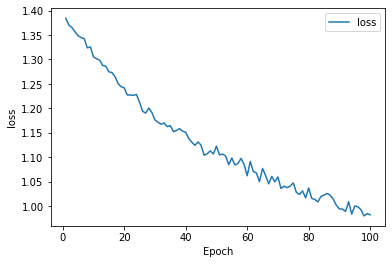

In [11]:
#loss와 acc시각화
import matplotlib.pyplot as plt
x_axis = []
for i in range(100):
  x_axis.append(i+1)
plt.plot(x_axis, loss_plot, label = "loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

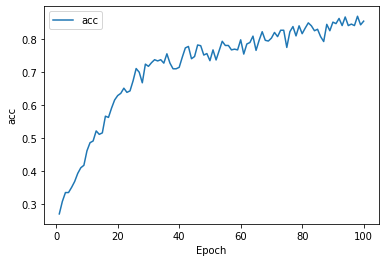

In [12]:
plt.plot(x_axis, acc_plot, label = "acc")
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

# 모델의 성능 검증하기

## 모델에 이미지 넣어서 결과보기

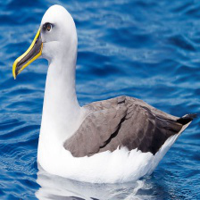

In [ ]:
#모델에 넣을 예싱 이미지 가지고오기
sample_url = "labeleddata/bird/016.jpg"
sample_image = Image.open(sample_url)
sample_image = sample_image.resize((200,200)).convert("RGB")
sample_image

In [ ]:
#모델에 넣을 수 있는 벡터 형태로 고치기
sample_tensor = transforms.PILToTensor()(sample_image)
sample_tensor = sample_tensor/255
print("===========================================")
print("숫자로 이미지 표현")
print(sample_tensor)
print("===========================================")
print("이미지 표현의 차원")
print(sample_tensor.shape)

숫자로 이미지 표현
tensor([[[0.0824, 0.0588, 0.0353,  ..., 0.1529, 0.1490, 0.1373],
         [0.1216, 0.0863, 0.0510,  ..., 0.1255, 0.1059, 0.0824],
         [0.0980, 0.0667, 0.0392,  ..., 0.0824, 0.0667, 0.0471],
         ...,
         [0.2863, 0.3020, 0.3137,  ..., 0.0863, 0.1333, 0.0902],
         [0.3412, 0.3333, 0.3216,  ..., 0.0314, 0.0275, 0.0275],
         [0.4196, 0.3961, 0.3608,  ..., 0.1333, 0.1451, 0.1137]],

        [[0.4235, 0.4078, 0.4078,  ..., 0.4667, 0.4549, 0.4392],
         [0.4667, 0.4392, 0.4314,  ..., 0.4667, 0.4706, 0.4667],
         [0.4392, 0.4196, 0.4157,  ..., 0.4588, 0.4784, 0.4902],
         ...,
         [0.5137, 0.5098, 0.5020,  ..., 0.3569, 0.4118, 0.4039],
         [0.5255, 0.5255, 0.5216,  ..., 0.2902, 0.2980, 0.3294],
         [0.6078, 0.6039, 0.5882,  ..., 0.3882, 0.4196, 0.4157]],

        [[0.6863, 0.6706, 0.6627,  ..., 0.6784, 0.6863, 0.6824],
         [0.7255, 0.6980, 0.6784,  ..., 0.6745, 0.6824, 0.6824],
         [0.6902, 0.6784, 0.6627,  ..., 0.6588,

In [ ]:
#모델에 넣어서 예측값 구하기
#모델에 넣어주기 위해 배치씌우기
model.eval()
sample_tensor = sample_tensor.unsqueeze(dim = 0)
output = model(sample_tensor)
output = output.squeeze()
print("===========================================")
print("예측결과")
print(output)

예측결과
tensor([0.0011, 0.9475, 0.0295, 0.0219], grad_fn=<SqueezeBackward0>)


## XAI를 이용해 인공지능이 추출한 특징 파악하기

## SA를 이용한 방법

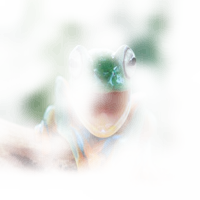

In [ ]:
from PIL import ImageFilter
from scipy.stats import beta
import matplotlib.pyplot as plt
model = AnimalClassifier()
model.load_state_dict(torch.load("save/week3.pt"))
#gradient를 이용해 추출한 특징 확인하기기
model.eval()
sample_url = "labeleddata/reptile/2.jpg"
sample_image = Image.open(sample_url)
sample_image = sample_image.resize((200,200)).convert("RGB")
sample_tensor = transforms.PILToTensor()(sample_image)
sample_tensor = sample_tensor/255
sample_tensor = sample_tensor.clone().detach().requires_grad_(True)
input = sample_tensor.unsqueeze(dim = 0)
output = model(input)
output = output.squeeze()
# loss = loss_fn(output, torch.tensor([0,1,0,0], dtype = torch.float32))
# loss.backward()
output[1].backward()
grads = torch.abs(sample_tensor.grad)
ones = torch.ones((1,200,200))
Rgrad = grads[0,:,:]/torch.max(grads[0,:,:])
Ggrad = grads[1,:,:]/torch.max(grads[1,:,:])
Bgrad = grads[2,:,:]/torch.max(grads[2,:,:])
ones = torch.ones((1,200,200))
Rgrad = ones - Rgrad.unsqueeze(dim = 0)
Ggrad = ones - Ggrad.unsqueeze(dim = 0)
Bgrad = ones - Bgrad.unsqueeze(dim = 0)
RGBgrad = torch.cat([Rgrad, Ggrad, Bgrad], dim = 0)
RGBimage = transforms.ToPILImage()(RGBgrad)
RGBimage = RGBimage.convert("L")
hmap = RGBimage.filter(ImageFilter.GaussianBlur(7))
img = np.array(sample_image)/255
hmap = np.array(hmap)/255
### scaling on heatmap

hmap = (hmap - hmap.min())/(hmap.max()-hmap.min()) # 0에서 1 사이로 조정
hmap = beta.cdf(hmap, 2, 5) # heatmap의 구분이 잘 되도록 0과 1쪽으로 조정
hmap.resize(200,200,1)
img_new = 1 - (1-img)*(1-hmap)
img_new = torch.tensor(img_new.transpose((2,0,1)))
img_new = transforms.ToPILImage()(img_new)
img_new

## LRP를 이용한 방법

In [ ]:
class AnimalClassifierforlrp(nn.Module):
  def __init__(self):
    super(AnimalClassifierforlrp, self).__init__()
    #Model 안에 layer층을 커스터마이징할할 수 있다.
    #앞서 살펴본 CNN을 활용해보도록 하자자
    self.model1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, stride = 3),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_features = 8),
        nn.Conv2d(in_channels = 8, out_channels = 5, kernel_size = 5, stride = 3),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.BatchNorm2d(num_features = 5)
    )
    self.outputlayer = nn.Linear(in_features = 125, out_features = 4)
  
  def forward(self, x):
    x1 = self.model1(x)
    x2 = x1.view(-1, 125)
    return self.outputlayer(x2)

In [ ]:
model = AnimalClassifierforlrp()
modelorigin = AnimalClassifier()
modelorigin.load_state_dict(torch.load("save/week3.pt"))
model.model1 = modelorigin.model1
model.outputlayer = modelorigin.outputlayer

<All keys matched successfully>

In [ ]:
from captum.attr import LRP
model.eval()
lrp = LRP(model)
#url을 바꾸어주면서 시도
sample_url = "labeleddata/reptile/1.jpg"
sample_image = Image.open(sample_url)
sample_image = sample_image.resize((200,200)).convert("RGB")
sample_tensor = transforms.PILToTensor()(sample_image)
sample_tensor = sample_tensor/255
sample_tensor = sample_tensor.clone().detach().requires_grad_(True)
input = sample_tensor.unsqueeze(dim = 0)

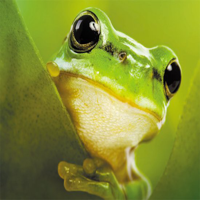

In [ ]:
sample_image

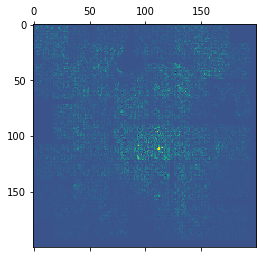

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

attr = lrp.attribute(input, target = 2, return_convergence_delta = False)
attr_pixel = attr.squeeze()

heatmap = torch.max(attr_pixel, dim = 0)[0].detach().numpy()
heatmap += np.min(heatmap)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)
plt.savefig("save/heatmap.jpg")

In [ ]:
import cv2

img = cv2.imread(sample_url)
# heatmap을 원본 이미지 크기에 맞게 변경
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap을 RGB 포맷으로 변환
heatmap = np.uint8(255 * heatmap)
# 히트맵으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4는 히트맵의 강도
superimposed_img = heatmap * 0.3 + img
cv2.imwrite("save/heatmaponimage.jpg", superimposed_img)

True

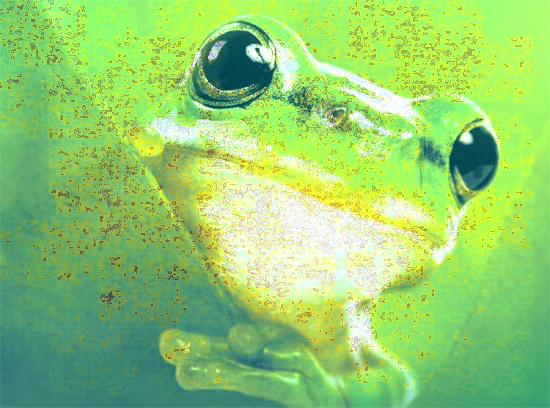

In [ ]:
heatmaponimage = Image.open("save/heatmaponimage.jpg")
heatmaponimage